# Analyzing Brain Recordings
This notebook takes a resting state EEG recording completed on the [NeuroFusion Explorer](https://usefusion.ai/playground) using the Muse S Headband - 4 channel EEG device.

## Activities
- Splitting the recording into fixed epochs - 5 seconds 
- Calculating & plotting the average power spectrum across epochs
- Running a fooof analysis on the average power spectrum and plotting the results 

In [111]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne


eeg_data = pd.read_csv('../explorer_datasets/rawBrainwaves_1715115077724.csv')
eeg_data.drop(columns=['index'], inplace=True)

df = eeg_data

# Assuming columns include 'Time' and EEG channel data
# Adjust according to your CSV file structure
sfreq = 256  # Replace with your sampling frequency
info = mne.create_info(ch_names=list(df.columns[1:]), sfreq=sfreq, ch_types='eeg')
# transpose data
df = df.values[:, 1:].T
df *= 1e-6 # convert from uV to V
raw = mne.io.RawArray(df, info)

# Set the montage if applicable (standard 10-20 system, etc.)
raw.set_montage('standard_1020')

# Create epochs
events = mne.make_fixed_length_events(raw, duration=5)  # Adjust duration
epochs = mne.Epochs(raw, events, tmin=0, tmax=0.5, baseline=None)

# Calculate psd for each epoch
alpha_band = (8, 12)
generic = (1, 40)

epochsSpectrum = epochs.compute_psd(fmin=generic[0], fmax=generic[1], method='welch', verbose=False)


epochsSpectrum

Creating RawArray with float64 data, n_channels=4, n_times=64200
    Range : 0 ... 64199 =      0.000 ...   250.777 secs
Ready.
Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated


Data type,Power Spectrum
Units,eeg: V²/Hz
Data source,Epochs
Number of epochs,50
Dims,"epoch, channel, freq"
Estimation method,welch
Number of channels,4
Number of frequency bins,20
Frequency range,1.98 – 39.69 Hz


Averaging across epochs...


/Users/oreogundipe/miniconda3/envs/fusion/lib/python3.8/site-packages/mne/viz/utils.py:165: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


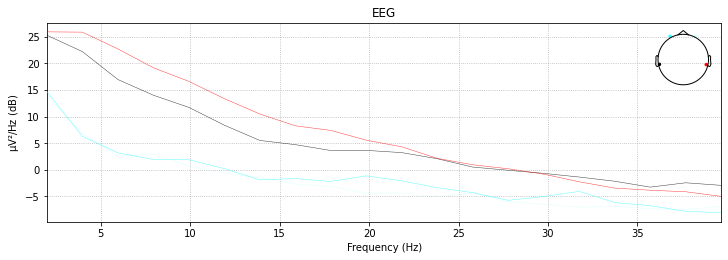

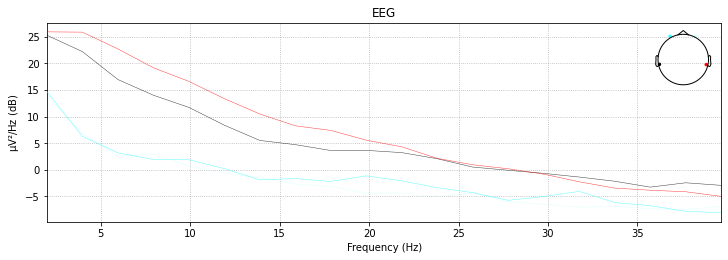

In [112]:
epochsSpectrum.plot()

Running FOOOFGroup across 4 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.98
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

[-8.5594534   2.38033502] []
[-10.30745171   1.57055348] [[21.12667436  0.2220662   5.08955347]
 [31.54481678  0.23118515  2.59266593]]
[-10.38287932   1.5365335 ] [[ 8.71551898  0.1124857   1.14261797]
 [25.78520709  0.12720523  1.45254233]]
[-7.8227171   2.84386413] []
Running FOOOFGroup across 4 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 1.98
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend

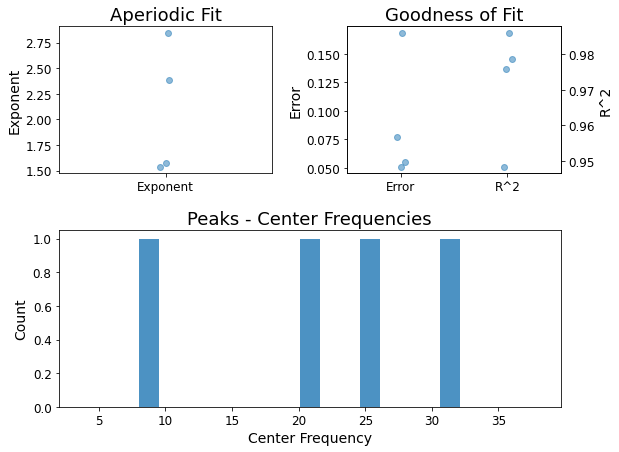

In [113]:
from fooof import FOOOFGroup

# Initialize a FOOOFGroup object
fg = FOOOFGroup(peak_width_limits=[1.0, 8.0], min_peak_height=0.1, peak_threshold=2.)

# Fit the FOOOF model across a group of PSDs
fg.fit(epochsSpectrum.freqs, epochsSpectrum.average().get_data(), freq_range=[1, 40])

# Retrieve the results
fooof_results = fg.get_results()

# You can save or view the results as needed
# For example, to print the parameters of the model:
for result in fooof_results:
    print(result.aperiodic_params, result.peak_params)

# Optionally, visualize the fits
fg.report()


Result at TP9:
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 40 Hz                        
                                 Frequency Resolution is 1.98 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -8.5595, 2.3803                                          
                                                                                                  
                                       0 peaks were found:                                    

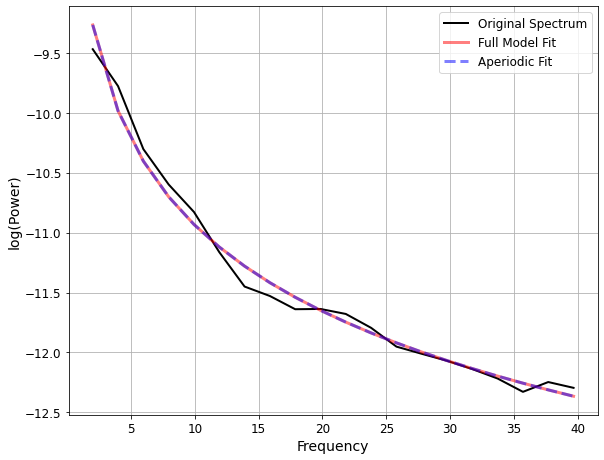

Result at AF7:
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 40 Hz                        
                                 Frequency Resolution is 1.98 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -10.3075, 1.5706                                         
                                                                                                  
                                       2 peaks were found:                                    

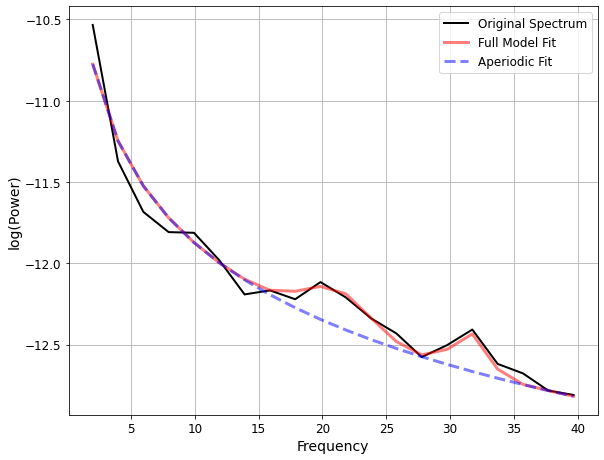

Result at AF8:
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 40 Hz                        
                                 Frequency Resolution is 1.98 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -10.3829, 1.5365                                         
                                                                                                  
                                       2 peaks were found:                                    

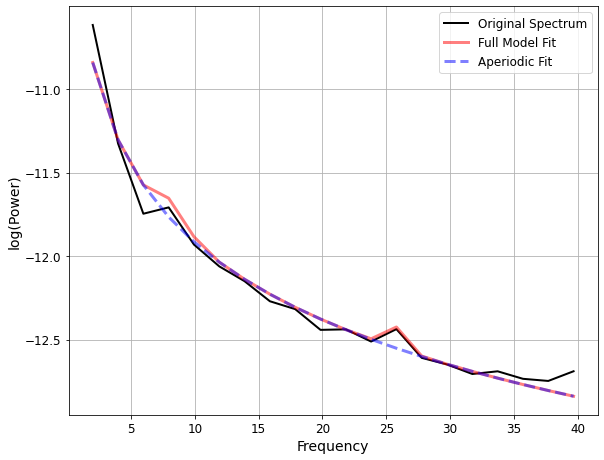

Result at TP10:
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 40 Hz                        
                                 Frequency Resolution is 1.98 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -7.8227, 2.8439                                          
                                                                                                  
                                       0 peaks were found:                                   

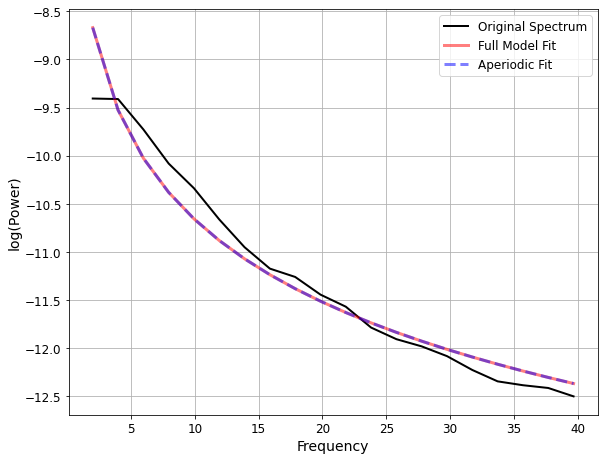

In [114]:
import matplotlib.pyplot as plt
ch_names = raw.info['ch_names']

# Define the indices to loop through
indices = [0, 1, 2, 3]

# Loop through the indices
for i in indices:
    # Get the result at the current index
    result = fg.get_fooof(i)
    
    # Print the result
    print(f"Result at {ch_names[i]}:")
    result.print_results()
    
    # Plot the result
    result.plot()
    plt.show()

## Chat GPT summary
The FOOOF results you've shared summarize the power spectrum analysis of EEG recordings from different electrodes (TP9, AF7, AF8, TP10) taken during a resting state session. Here's a simplified explanation of the findings suitable for someone with little EEG experience:

## Basic Concepts:
- Power Spectrum: This shows how much power (signal strength) exists at different frequencies in the EEG. It helps us understand what types of brain activities are occurring.
- Aperiodic Component: Represents the background activity of the brain that isn't part of specific brain waves but forms a baseline over which the brain waves appear.
- Peaks: These are specific points in the spectrum where there's a noticeable increase in power, indicating brain waves at those frequencies.

## Specific Results:
### TP9 and TP10 (Left and Right Temporal Areas):
- Aperiodic Parameters:
Offset: Essentially the starting point of the power spectrum on a logarithmic scale. A lower number means a lower starting power.
Exponent: Describes how quickly the power decreases as the frequency increases. Higher values mean a steeper decline.
- Peaks Found: Both TP9 and TP10 showed no peaks, suggesting that there were no distinct, strong brain wave activities at these electrodes during the recording. This might indicate a very relaxed state with no significant localized activity in these temporal regions.
- Goodness of Fit: Both locations had high R^2 values (above 0.94), meaning the model accurately represents the recorded data, even though no peaks were identified. The error values give an idea of how much the model deviates from the actual data, with lower values indicating better fits.

### AF7 and AF8 (Frontal Areas):
- Aperiodic Parameters: Similar to TP9 and TP10, but the offsets are generally lower, and the exponents are smaller, indicating a less steep decline in power across frequencies.
- Peaks Found:
AF7: Two peaks were identified at around 21 Hz and 31 Hz, corresponding to Beta and low Gamma frequencies. These frequencies are often linked to active thinking, focus, or anxiety.
AF8: Two peaks at about 9 Hz and 26 Hz. The first is in the Alpha range (associated with relaxation or idle brain) and the second in the Beta range.
- Goodness of Fit: These areas also showed good model fit (R^2 above 0.97), with relatively low error values.

## General Interpretation:
- Temporal Regions (TP9, TP10): The lack of distinct peaks could suggest a very uniform, calm state in these brain regions, which might be expected during a resting state recording.
- Frontal Regions (AF7, AF8): The presence of Beta and Gamma peaks indicates more active processing or alertness in these areas, which could be due to residual thoughts, planning, or spontaneous brain activities even during rest.

These results help in understanding different aspects of brain function during rest, particularly how different brain regions might be more or less active and in what ways. The absence or presence of specific brain wave peaks provides clues about what might be going on in the mind during the recording.